In [145]:
import xml.etree.ElementTree as ET
import pandas as pd
import geopy
import math
import matplotlib.pyplot as plt
from geopy.distance import distance

In [146]:
# Process the .gpx xml file

tree = ET.parse('GDMBR.gpx')
root = tree.getroot()

myList = []

for child in root[1][1]:
    
    lat = child.attrib['lat']
    lon = child.attrib['lon']
    ele = child[0].text
    
    myList.append([lat,lon,ele])
    
df = pd.DataFrame(myList, columns=['lat', 'lon', 'ele'])   

In [147]:
df[['lat_prev', 'lon_prev', 'ele_prev']] = df[['lat', 'lon', 'ele']].shift()

In [148]:
df = df.astype(float)

In [149]:
def dfDistance(row):
    
    if math.isnan(row['lat_prev']):
        return 0
    
    return distance((row['lat'],row['lon']),
                    (row['lat_prev'],row['lon_prev'])).kilometers


In [150]:
df['dist'] = df.apply(dfDistance, axis=1)
df = df[df['dist'] > 0]

# calculate the gradient between the points
df['eleDiff'] = df['ele'] - df['ele_prev']
df['grade'] = df['eleDiff']/(df['dist']*1000)

Remove points and recalculate metrics until there are no more erroneous grades.

In [151]:
badGrades = (len(df[abs(df['grade']) > .35]) >= 1)

while badGrades:
    
    print(len(df))
    
    df = df[(abs(df['grade']) < .35) | (df['grade'].isna())]
    
    df[['lat_prev', 'lon_prev', 'ele_prev']] = df[['lat', 'lon', 'ele']].shift()
    df['dist'] = df.apply(dfDistance, axis=1)

    # calculate the gradient between the points
    df['eleDiff'] = df['ele'] - df['ele_prev']
    df['grade'] = df['eleDiff']/(df['dist']*1000)
    
    badGrades = (len(df[abs(df['grade']) > .35]) >= 1)

18047
18011
18006
18003
18002


In [152]:
df['angle'] = np.rad2deg(np.arctan(df['grade']))

In [153]:
df

,lat,lon,ele,lat_prev,lon_prev,ele_prev,dist,eleDiff,grade,angle
1,51.160931,-115.559829,1406.765991,NaN,NaN,NaN,0.000000,NaN,NaN,NaN
2,51.160872,-115.559809,1406.886963,51.160931,-115.559829,1406.765991,0.006711,0.120972,0.018025,1.032654
3,51.160814,-115.559683,1406.536011,51.160872,-115.559809,1406.886963,0.010924,-0.350952,-0.032128,-1.840139
4,51.160696,-115.559269,1405.836060,51.160814,-115.559683,1406.536011,0.031798,-0.699951,-0.022013,-1.261028
5,51.160490,-115.558975,1405.931030,51.160696,-115.559269,1405.836060,0.030793,0.094970,0.003084,0.176707
...,...,...,...,...,...,...,...,...,...,...
18046,31.353338,-108.531870,1423.000000,31.394864,-108.561707,1439.000000,5.408821,-16.000000,-0.002958,-0.169488
18047,31.350737,-108.531126,1422.000000,31.353338,-108.531870,1423.000000,0.296949,-1.000000,-0.003368,-0.192947
18048,31.335328,-108.531163,1418.000000,31.350737,-108.531126,1422.000000,1.708482,-4.000000,-0.002341,-0.134144
18049,31.333430,-108.530234,1419.000000,31.335328,-108.531163,1418.000000,0.228259,1.000000,0.004381,0.251010


In [154]:
calcDF = df[['dist','grade']].iloc[1:].copy()

<AxesSubplot:>

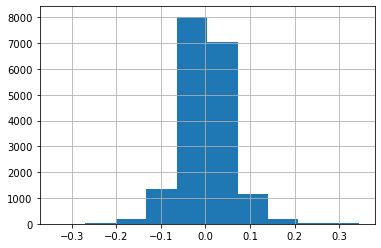

In [155]:
calcDF['grade'].hist()

In [158]:
calcDF['cumDist'] = calcDF['dist'].cumsum()

In [159]:
calcDF

,dist,grade,cumDist
2,0.006711,0.018025,0.006711
3,0.010924,-0.032128,0.017635
4,0.031798,-0.022013,0.049433
5,0.030793,0.003084,0.080226
6,0.039826,0.015742,0.120052
...,...,...,...
18046,5.408821,-0.002958,4358.584151
18047,0.296949,-0.003368,4358.881100
18048,1.708482,-0.002341,4360.589582
18049,0.228259,0.004381,4360.817841


# Power

In [ ]:
class vehicle:
    '''Class of type vehicle, where A is area, 
    CD is drag coefficient, eta is drivetrain efficiency,
    and m is mass of rider and bike.'''
    
    def __init__(self, CD, A, mass,eta):
        self.CD = CD
        self.A = A
        self.mass = mass
        self.eta = eta
        
def Pd(p,v,A,Cd,eta=.96):
    '''Calculate power to overcome aerodynamic drag.'''
    return .5*p*v**3*A*Cd/eta
def Pr(v,m,Cr,eta=.96):
    '''Calculate power to overcome rolling resistance'''
    return v*m*9.81*Cr/eta
def Pc(v,m,s,eta=.96):
    '''Calculate power to climb a grade(slope).'''
    return v*m*9.81*np.sin(np.arctan(s))/eta
def Pa(v,m,a,eta=.96):
    '''Calculate power to accelerate.'''
    return v*m*a/eta

crr = [.0035,.0039,.005,.0056,.0061,.0063,.0065,.0067,.0069,.0071,.0072]
vs = [0,2,8,12,18,22,27,33,39,46,50]

crr_df = pd.DataFrame(crr, index=vs, columns=['Crr'])
crr_df = crr_df.reindex(np.arange(0,50.01,.01)).interpolate('pchip')
Crr = interp1d(crr_df.index, crr_df['Crr'])

In [ ]:
def next_velocity(time_delta, current_velocity, power_in, vehicle, slope, density=1.07):
    # power to roll
    PR = Pr(v=current_velocity, m=vehicle.mass, Cr=Crr(current_velocity), eta=vehicle.eta)
    # power to overcome drag
    PD = Pd(p=density,v=current_velocity,A=vehicle.A, Cd=vehicle.CD, eta=vehicle.eta)
    # power to climb
    PC = Pc(v=current_velocity, m=vehicle.mass, s=slope, eta=vehicle.eta)
    # power to accelerate
    PA = (power_in - PR - PD - PC)*vehicle.eta
    A = PA/(vehicle.mass*current_velocity)
    NV = current_velocity+A*time_delta
    return NV, PA, PD, PR, PC

In [ ]:
def step_speeds(ts, input_df, vehicle, course_df):
    vel=0
    dist=0
    velocities = []
    pas = []
    pds = []
    prs = []
    pcs = []

    while dist < totalDist:
        n_vel, PA, PD, PR, PC = next_velocity(ts,vel,input_power,vehicle,slope)
        velocities.append(n_vel)
        pas.append(PA)
        prs.append(PR)
        pds.append(PD)
        pcs.append(PC)
        vel=n_vel

    input_df['velocity'] = velocities
    input_df['pa'] = pas
    input_df['pd'] = pds
    input_df['pr'] = prs
    input_df['pc'] = pcs
    
    return input_df

In [ ]:
input_df = step_speeds(ts=.1,rkg=80,power_func)